# ions_phonons

In [2]:
# Import libraries

import math
import numpy as np
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
from scipy.optimize import curve_fit
from scipy import linalg
import re
import scipy.integrate as spi
pi = math.pi

In [119]:
############## PARAMETERS ##############
# time step
dt = 0.1 # micro s
# final time
t_fin = 200 # micro s
# number of time steps
t_steps = t_fin/dt
# Detune frequency
delta = 2*pi*0.015 # 2pi x MHz
# Lamb-Dicke parameter
eta = 0.05
# Frequencies ratio Omega/delta
freq_ratio = 0.001
# Energy difference betweeen two atomic levels
#w_0 = 2*pi*0.05 # 2pi x MHz
#W = delta*freq_ratio
# Vibrational frequency
#w_t = 2*pi*0.01 # 2pi x  MHz

# Pauli x matrix
sgm_x = np.array([[0.,1.],[1.,0.]])
# Pauli y matrix
sgm_y = np.array([[0.,-1j],[1j,0.]])
#Pauli z matrix
sgm_z = np.array([[1.,0.],[0.,-1.]])
# 2x2 identity
id_2 = np.eye(2)
# Ladder operators for phonon number
a_dagger = np.array([[0.,1.],[0.,0.]])
a = np.array([[0.,0.],[1.,0.]])
# time vector
t= np.arange(0, t_fin + dt, dt)
# state at time t
state = np.zeros(shape=(8,1))
# Define ground state
s_1 = np.array([[0.],[1.]])
s_2 = np.array([[0.],[1.]])
vib = np.array([[0.],[1.]])
gs = np.kron(s_1, np.kron(s_2, vib))


def H_1(t, freq_ratio):
    return 0.5*freq_ratio*delta*np.kron(np.kron(sgm_x,id_2) + np.kron(id_2,sgm_x), a_dagger*np.exp(-1j*delta*t) + a*np.exp(1j*delta*t))
    
def D(x):
    return linalg.expm(np.kron(x, a_dagger)- np.kron(x.conj().T, a))

def alpha(t,freq_ratio):
    return 1j*freq_ratio*(1- np.exp(1j*delta*t))

def Phi(t, freq_ratio):
    return (freq_ratio**2)*(delta*t - np.sin(delta*t))

def S_x():
    return np.kron(sgm_x, id_2) + np.kron(id_2, sgm_x) 

def U(t, freq_ratio):
    A = alpha(t,freq_ratio)*S_x()
    d = D(A)
    C = linalg.expm(1j*Phi(t, freq_ratio)*np.kron(S_x() @ S_x(), id_2))
    U = d @ C
    return U
def expectation_z1(state):
    return float(np.real(state.conj().T @ np.kron(np.kron(sgm_z, id_2),id_2) @ state))
def expectation_z2(state):
    return float(np.real(state.conj().T @ np.kron(np.kron(id_2, sgm_z),id_2) @ state))


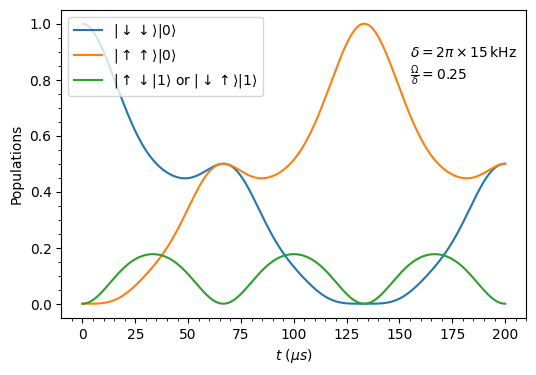

In [32]:

pop00 = []
pop00_excited = []
pop11 = []
pop11_excited = []
pop10 = []
pop1001_excited = []
pop01 = []
pop01_excited = []
norm = []
sum_pop = []
for kk in np.arange(0, int(t_steps)+1, 1):
    state = U(t[kk], freq_ratio) @ gs
    #state = linalg.expm(-1j*t[kk]*H_1(t[kk])) @gs
    pop00.append(np.abs(state[7])**2)
    pop11.append(np.abs(state[1]**2))
    pop1001_excited.append(0.5*np.abs(state[2])**2 + 0.5*np.abs(state[4])**2)
    #sum_pop.append(pop00[kk] + pop11[kk] + pop1001_excited[kk])

# Plot of populations
cmap = plt.get_cmap('tab20')
w = 6
h = 4
fig = plt.figure(figsize=(w,h))
plt.plot(t,pop00, color = cmap(0), label = '$| \downarrow \downarrow \\rangle | 0\\rangle$')
plt.plot(t,pop11, color = cmap(2), label = '$| \\uparrow \\uparrow \\rangle | 0\\rangle$')
plt.plot(t,pop1001_excited, color = cmap(4), label = '$|\\uparrow \\downarrow|   1 \\rangle$ or $|\\downarrow \\uparrow\\rangle |   1 \\rangle$')
#plt.plot(t, sum_pop)
plt.xlabel('$t \,\,(\mu s)$')
plt.ylabel('Populations')
text = '$\delta = 2\pi\\times 15\,\mathrm{kHz}$\n$\\frac{\Omega}{\delta} = 0.25$'
plt.text(155, 0.8,text)
plt.minorticks_on()
plt.legend()
plt.show()
 

<Figure size 800x1000 with 0 Axes>

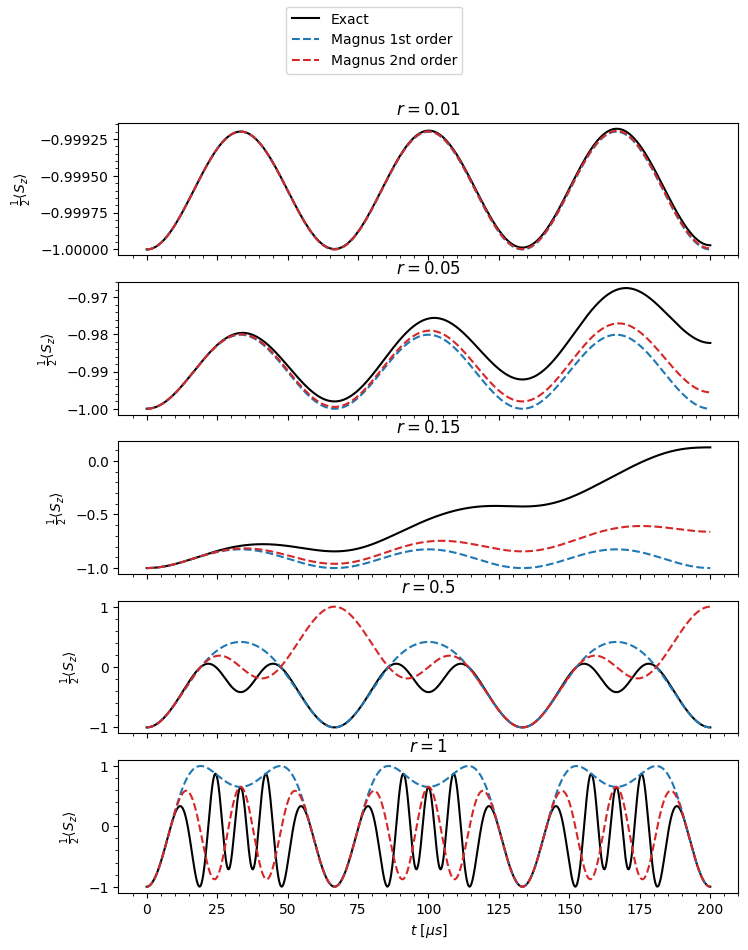

In [131]:

freq_ratio = [0.01, 0.05, 0.15, 0.5, 1]

# Dyson first order
def D1(t_final, freq_ratio):
    D1 = np.zeros(shape=(8,8), dtype = complex)
    for kk in range(0,len(state)):
        for jj in range(0 ,len(state)):
            integrand = lambda t : H_1(t, freq_ratio)[kk][jj]
            result, error = spi.quad(integrand, 0., t_final, complex_func = True)
            D1[kk][jj] = -1j*result
    return D1

# First magnus coefficient
def M1(t, freq_ratio):
        return -2*freq_ratio*np.sin(0.5*delta*t)*np.kron(S_x(), \
        np.exp(0.5j*delta*t)*a - np.exp(-0.5j*delta*t)*a_dagger)
# Second magnus coefficient
def M2(t, freq_ratio):
        return -1j*(freq_ratio**2)*delta*(t - np.sin(delta*t)/delta)*np.kron( np.kron(sgm_x, sgm_x), id_2)


# Plot of mean <sgm_z>
cmap = plt.get_cmap('tab20')
w = 8
h = 10
fig = plt.figure(figsize=(w,h))
fig, axs = plt.subplots(len(freq_ratio), figsize= (w,h),sharex= True)

# Mean Z values
I = np.kron(np.kron(id_2,id_2),id_2)
for jj in range(0, len(freq_ratio)):
    mean_z = []
    mean_z1 = []
    mean_z2 = []
    mean_z1d = [] 
    for kk in np.arange(0, int(t_steps)+1, 1):
        state = U(t[kk], freq_ratio[jj]) @ gs
        state1 = linalg.expm(M1(t[kk], freq_ratio[jj])) @ gs
        state2 = linalg.expm(M1(t[kk], freq_ratio[jj]) + M2(t[kk], freq_ratio[jj])) @ gs
        #state1d = (I + D1(t[kk], freq_ratio[jj])) @ gs 
        mean_z.append(0.5*expectation_z1(state) + 0.5*expectation_z2(state))
        mean_z1.append(0.5*expectation_z1(state1) + 0.5*expectation_z2(state1))
        mean_z2.append(0.5*expectation_z1(state2) + 0.5*expectation_z2(state2))
        #mean_z1d.append(0.5*expectation_z1(state1d) + 0.5*expectation_z2(state1d))

    axs[jj].plot(t, mean_z, color = 'k', label = 'Exact')
    axs[jj].plot(t, mean_z1,  color = cmap(0), linestyle = 'dashed',label = 'Magnus 1st order')
    axs[jj].plot(t, mean_z2,  color = cmap(6), linestyle = 'dashed',label = 'Magnus 2nd order')
    #axs[jj].plot(t, mean_z1d,  color = cmap(6), linestyle = 'dashed',label = 'Dyson 1st order')
    axs[jj].minorticks_on()
    axs[jj].set_title('$r=$' + str(freq_ratio[jj]))

for ax in axs.flat:
    ax.set(xlabel='$t$ [$\mu s$]', ylabel='$\\frac{1}{2}\langle S_z\\rangle$')
for ax in axs.flat:
    ax.label_outer()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.show()
